In [80]:
import pandas as pd
import numpy as np
import math
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostRegressor, Pool, metrics, cv

import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

In [65]:
data = pd.read_excel('Статистика_для_графиков_3_д_ТЭЦ2_УРУТ_130.xlsx', sheet_name='Лист1')

In [66]:
data = data.drop(columns=["Дата"]).iloc[:, :-3]

## **Проверим на пустые значения**

In [67]:
data.isna().sum()

Выработка электроэнергии ТА гр.130                        0
Отпуск тепла из ТО ТА гр.130                              0
Удельный расход условного топлива на отпуск э/э гр.130    0
dtype: int64

In [68]:
data.dtypes

Выработка электроэнергии ТА гр.130                        float64
Отпуск тепла из ТО ТА гр.130                              float64
Удельный расход условного топлива на отпуск э/э гр.130    float64
dtype: object

## **Делим на выборки**

In [69]:
X = data.drop(columns=['Удельный расход условного топлива на отпуск э/э гр.130'])
Y = data['Удельный расход условного топлива на отпуск э/э гр.130']

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

## **Подберём модель по которой можно будет предсказывать**

**Разберём модели CatBoostRegressor, RandomForestRegressor и LinearRegression**

### **LinearRegression**

In [8]:
lr = LinearRegression()

lr.fit(X_train, Y_train)

prediction_lr = lr.predict(X_test)

In [9]:
print(f'mean_squared_error: {math.sqrt(mean_squared_error(Y_test, prediction_lr))}')
print(f'mean_absolute_error: {mean_absolute_error(Y_test, prediction_lr)}')
print(f'median_absolute_error: {median_absolute_error(Y_test, prediction_lr)}')
print(f'r2_score: {r2_score(Y_test, prediction_lr)}')

mean_squared_error: 30.334219784204844
mean_absolute_error: 24.082724049740875
median_absolute_error: 20.374034095981244
r2_score: 0.7161998602530684


In [10]:
LR_pereb = LinearRegression()

params = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1],
    'positive': [True, False]
}

# создадим объект GridSearchCV
search_LR = GridSearchCV(LR_pereb, params, n_jobs=-1, cv=5, refit=True, scoring='neg_mean_absolute_error')

# запустим поиск
search_LR.fit(X_train, Y_train)

# выведем наилучшие параметры
print(search_LR.best_params_)

# применяем параметры
search_LR = search_LR.best_estimator_

prediction_search_LR = search_LR.predict(X_test)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}


In [11]:
print(f'mean_squared_error: {math.sqrt(mean_squared_error(Y_test, prediction_search_LR))}')
print(f'mean_absolute_error: {mean_absolute_error(Y_test, prediction_search_LR)}')
print(f'median_absolute_error: {median_absolute_error(Y_test, prediction_search_LR)}')
print(f'r2_score: {r2_score(Y_test, prediction_search_LR)}')

mean_squared_error: 30.334219784204844
mean_absolute_error: 24.082724049740875
median_absolute_error: 20.374034095981244
r2_score: 0.7161998602530684


### **RandomForestRegressor**

In [12]:
rfr = RandomForestRegressor()

rfr.fit(X_train, Y_train)

prediction_rfr = rfr.predict(X_test)

In [13]:
print(f'mean_squared_error: {math.sqrt(mean_squared_error(Y_test, prediction_rfr))}')
print(f'mean_absolute_error: {mean_absolute_error(Y_test, prediction_rfr)}')
print(f'median_absolute_error: {median_absolute_error(Y_test, prediction_rfr)}')
print(f'r2_score: {r2_score(Y_test, prediction_rfr)}')

mean_squared_error: 16.89776144099892
mean_absolute_error: 11.545244846524394
median_absolute_error: 8.130005474999962
r2_score: 0.9119346032761959


In [14]:
rfr_pereb = RandomForestRegressor()

params = {
    'n_estimators': [100, 200, 300],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'max_depth': [3, 4, 6, 10],
    'min_samples_split': [2, 4, 5, 6],
    'min_samples_leaf': [1, 2, 4, 6]
}

# создадим объект GridSearchCV
search_rfr = GridSearchCV(rfr_pereb, params, n_jobs=-1, cv=5, refit=True, scoring='neg_mean_absolute_error')

# запустим поиск
search_rfr.fit(X_train, Y_train)

# выведем наилучшие параметры
print(search_rfr.best_params_)

# применяем параметры
search_rfr = search_rfr.best_estimator_

prediction_search_rfr = search_rfr.predict(X_test)

{'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 200}


In [15]:
print(f'mean_squared_error: {math.sqrt(mean_squared_error(Y_test, prediction_search_rfr))}')
print(f'mean_absolute_error: {mean_absolute_error(Y_test, prediction_search_rfr)}')
print(f'median_absolute_error: {median_absolute_error(Y_test, prediction_search_rfr)}')
print(f'r2_score: {r2_score(Y_test, prediction_search_rfr)}')

mean_squared_error: 16.553171348319225
mean_absolute_error: 11.417425851350052
median_absolute_error: 7.723452140606781
r2_score: 0.9154897535793997


### **CatBoostRegressor**

In [16]:
cbr = CatBoostRegressor()

cbr.fit(X_train, Y_train, verbose=500)

prediction_cbr = cbr.predict(X_test)

Learning rate set to 0.040449
0:	learn: 52.6780644	total: 122ms	remaining: 2m 2s
500:	learn: 12.7150954	total: 998ms	remaining: 994ms
999:	learn: 10.3321747	total: 1.86s	remaining: 0us


In [17]:
print(f'mean_squared_error: {math.sqrt(mean_squared_error(Y_test, prediction_cbr))}')
print(f'mean_absolute_error: {mean_absolute_error(Y_test, prediction_cbr)}')
print(f'median_absolute_error: {median_absolute_error(Y_test, prediction_cbr)}')
print(f'r2_score: {r2_score(Y_test, prediction_cbr)}')

mean_squared_error: 17.064845516334813
mean_absolute_error: 11.83644302898369
median_absolute_error: 8.636002482898704
r2_score: 0.9101844220316506


In [18]:
cbr_litlleBit_params = CatBoostRegressor(iterations=5001,
                                         depth=7,
                                         rsm=1,
                                         grow_policy='Depthwise',
                                         verbose=1000,
                                         task_type='GPU'
                                        )

cbr_litlleBit_params.fit(X_train, Y_train)

prediction_cbr_litlleBit_params = cbr_litlleBit_params.predict(X_test)

Learning rate set to 0.015297
0:	learn: 53.7887838	total: 25.5ms	remaining: 2m 7s
1000:	learn: 8.4166479	total: 6.12s	remaining: 24.5s
2000:	learn: 6.2242053	total: 13.5s	remaining: 20.3s
3000:	learn: 5.2737594	total: 22.9s	remaining: 15.2s
4000:	learn: 4.8257370	total: 32.5s	remaining: 8.13s
5000:	learn: 4.5870797	total: 42.1s	remaining: 0us


In [19]:
print(f'mean_squared_error: {math.sqrt(mean_squared_error(Y_test, prediction_cbr_litlleBit_params))}')
print(f'mean_absolute_error: {mean_absolute_error(Y_test, prediction_cbr_litlleBit_params)}')
print(f'median_absolute_error: {median_absolute_error(Y_test, prediction_cbr_litlleBit_params)}')
print(f'r2_score: {r2_score(Y_test, prediction_cbr_litlleBit_params)}')

mean_squared_error: 19.065083764999827
mean_absolute_error: 12.69165368719125
median_absolute_error: 8.587262758994399
r2_score: 0.8878951550662814


In [20]:
search_CBR = CatBoostRegressor(iterations=5001,
                                    rsm=1,
                                    early_stopping_rounds=100,
                                    grow_policy='Depthwise',
                                    depth=7,
                                    loss_function='RMSE',
                                    eval_metric='RMSE',
                                    l2_leaf_reg=10,
                                    learning_rate=0.01,
                                    verbose=1000,
                                    task_type='GPU'
                                    )

search_CBR.fit(X_train, Y_train)

prediction_search_CBR = search_CBR.predict(X_test)

0:	learn: 54.0892741	total: 12.3ms	remaining: 1m 1s
1000:	learn: 12.1033936	total: 9.62s	remaining: 38.4s
2000:	learn: 9.7791996	total: 19.5s	remaining: 29.2s
3000:	learn: 8.7232786	total: 28.9s	remaining: 19.3s
4000:	learn: 7.8588536	total: 38.1s	remaining: 9.53s
5000:	learn: 7.1429142	total: 47.3s	remaining: 0us


In [21]:
print(f'mean_squared_error: {math.sqrt(mean_squared_error(Y_test, prediction_search_CBR))}')
print(f'mean_absolute_error: {mean_absolute_error(Y_test, prediction_search_CBR)}')
print(f'median_absolute_error: {median_absolute_error(Y_test, prediction_search_CBR)}')
print(f'r2_score: {r2_score(Y_test, prediction_search_CBR)}')

mean_squared_error: 17.798424903642864
mean_absolute_error: 11.73028793187514
median_absolute_error: 7.527233677762638
r2_score: 0.902296507594079


## **Сделаем таблицу для сравнения результатов**

In [22]:
comparison_table = pd.DataFrame(
    {'models': ['lr', 'search_LR', 'rfr', 'search_rfr', 'cbr', 'cbr_litlleBit_params', 'search_CBR'],
     
    'mean_squared_error': [math.sqrt(mean_squared_error(Y_test, prediction_lr)),
                            math.sqrt(mean_squared_error(Y_test, prediction_search_LR)),
                            math.sqrt(mean_squared_error(Y_test, prediction_rfr)),
                            math.sqrt(mean_squared_error(Y_test, prediction_search_rfr)),
                            math.sqrt(mean_squared_error(Y_test, prediction_cbr)),
                            math.sqrt(mean_squared_error(Y_test, prediction_cbr_litlleBit_params)),
                            math.sqrt(mean_squared_error(Y_test, prediction_search_CBR))],

    'mean_absolute_error':[mean_absolute_error(Y_test, prediction_lr),
                           mean_absolute_error(Y_test, prediction_search_LR),
                           mean_absolute_error(Y_test, prediction_rfr),
                           mean_absolute_error(Y_test, prediction_search_rfr),
                           mean_absolute_error(Y_test, prediction_cbr),
                           mean_absolute_error(Y_test, prediction_cbr_litlleBit_params),
                           mean_absolute_error(Y_test, prediction_search_CBR)],\

    'median_absolute_error': [median_absolute_error(Y_test, prediction_lr),
                              median_absolute_error(Y_test, prediction_search_LR),
                              median_absolute_error(Y_test, prediction_rfr),
                              median_absolute_error(Y_test, prediction_search_rfr),
                              median_absolute_error(Y_test, prediction_cbr),
                              median_absolute_error(Y_test, prediction_cbr_litlleBit_params),
                              median_absolute_error(Y_test, prediction_search_CBR)],
                              
    'r2_score': [r2_score(Y_test, prediction_lr), 
                r2_score(Y_test, prediction_search_LR),
                r2_score(Y_test, prediction_rfr),
                r2_score(Y_test, prediction_search_rfr),
                r2_score(Y_test, prediction_cbr),
                r2_score(Y_test, prediction_cbr_litlleBit_params),
                r2_score(Y_test, prediction_search_CBR)]
    })

In [23]:
comparison_table

,models,mean_squared_error,mean_absolute_error,median_absolute_error,r2_score
0,lr,30.334220,24.082724,20.374034,0.716200
1,search_LR,30.334220,24.082724,20.374034,0.716200
2,rfr,16.897761,11.545245,8.130005,0.911935
3,search_rfr,16.553171,11.417426,7.723452,0.915490
4,cbr,17.064846,11.836443,8.636002,0.910184
5,cbr_litlleBit_params,19.065084,12.691654,8.587263,0.887895
6,search_CBR,17.798425,11.730288,7.527234,0.902297


## **Из всего этого хоршо подходит CatBoostRegressor из коробки(cbr), но CatBoostRegressor с подкручеными параметрами я бы доверял больше поэтому оставим его тоже. Но и RandomForestRegressor показал себя посмотрим на него тоже и выберим модели для финального испытания**

### **Обучим модели на всех данных**

In [24]:
cbr.fit(X, Y, verbose=500)

prediction_cbr = cbr.predict(X)

Learning rate set to 0.041504
0:	learn: 53.0297492	total: 2.69ms	remaining: 2.69s
500:	learn: 12.9915347	total: 857ms	remaining: 854ms
999:	learn: 10.6172882	total: 1.73s	remaining: 0us


In [25]:
print(f'mean_squared_error: {math.sqrt(mean_squared_error(Y, prediction_cbr))}')
print(f'mean_absolute_error: {mean_absolute_error(Y, prediction_cbr)}')
print(f'median_absolute_error: {median_absolute_error(Y, prediction_cbr)}')
print(f'r2_score: {r2_score(Y, prediction_cbr)}')

mean_squared_error: 10.617287934592882
mean_absolute_error: 8.031329901045604
median_absolute_error: 6.3158566975016015
r2_score: 0.9623670510823832


In [26]:
search_CBR.fit(X, Y)

prediction_search_CBR = search_CBR.predict(X)

0:	learn: 54.4605593	total: 9.32ms	remaining: 46.6s
1000:	learn: 11.9433931	total: 7.67s	remaining: 30.6s
2000:	learn: 10.0631596	total: 15.6s	remaining: 23.4s
3000:	learn: 9.2106337	total: 25.2s	remaining: 16.8s
4000:	learn: 8.4801483	total: 35.1s	remaining: 8.78s
5000:	learn: 7.8934117	total: 44.2s	remaining: 0us


In [27]:
print(f'mean_squared_error: {math.sqrt(mean_squared_error(Y, prediction_search_CBR))}')
print(f'mean_absolute_error: {mean_absolute_error(Y, prediction_search_CBR)}')
print(f'median_absolute_error: {median_absolute_error(Y, prediction_search_CBR)}')
print(f'r2_score: {r2_score(Y, prediction_search_CBR)}')

mean_squared_error: 7.8934187861997955
mean_absolute_error: 5.420095459179627
median_absolute_error: 3.9967100214070683
r2_score: 0.9791996161152253


In [28]:
cbr_litlleBit_params.fit(X, Y)

prediction_cbr_litlleBit_params = cbr_litlleBit_params.predict(X)

Learning rate set to 0.015627
0:	learn: 54.1521133	total: 15ms	remaining: 1m 14s
1000:	learn: 8.9197147	total: 8.31s	remaining: 33.2s
2000:	learn: 7.1169246	total: 18.5s	remaining: 27.8s
3000:	learn: 6.3843942	total: 28.7s	remaining: 19.2s
4000:	learn: 6.0349473	total: 38.5s	remaining: 9.63s
5000:	learn: 5.8436646	total: 46.9s	remaining: 0us


In [29]:
print(f'mean_squared_error: {math.sqrt(mean_squared_error(Y, prediction_cbr_litlleBit_params))}')
print(f'mean_absolute_error: {mean_absolute_error(Y, prediction_cbr_litlleBit_params)}')
print(f'median_absolute_error: {median_absolute_error(Y, prediction_cbr_litlleBit_params)}')
print(f'r2_score: {r2_score(Y, prediction_cbr_litlleBit_params)}')

mean_squared_error: 5.843666662675375
mean_absolute_error: 3.0117361293196465
median_absolute_error: 1.6936677063114018
r2_score: 0.9885998141934244


In [30]:
rfr.fit(X, Y)

prediction_rfr = rfr.predict(X)

In [31]:
print(f'mean_squared_error: {math.sqrt(mean_squared_error(Y, prediction_rfr))}')
print(f'mean_absolute_error: {mean_absolute_error(Y, prediction_rfr)}')
print(f'median_absolute_error: {median_absolute_error(Y, prediction_rfr)}')
print(f'r2_score: {r2_score(Y, prediction_rfr)}')

mean_squared_error: 6.959747985322076
mean_absolute_error: 4.638590737247721
median_absolute_error: 2.9840464549997137
r2_score: 0.9838293272520674


In [43]:
search_rfr.fit(X, Y)

prediction_search_rfr = search_rfr.predict(X)

In [44]:
print(f'mean_squared_error: {math.sqrt(mean_squared_error(Y, prediction_search_rfr))}')
print(f'mean_absolute_error: {mean_absolute_error(Y, prediction_search_rfr)}')
print(f'median_absolute_error: {median_absolute_error(Y, prediction_search_rfr)}')
print(f'r2_score: {r2_score(Y, prediction_search_rfr)}')

mean_squared_error: 8.414028052151854
mean_absolute_error: 5.648280367483874
median_absolute_error: 3.838819977198
r2_score: 0.9763653610904163


### **Xммм... Все модели хорошо себя показали. Но проверим их в ещё одном испытании и выберем лучшую**

# **Сделаем финальное испытание для моделей**

## **Разделим датасет на фичи дат: год, месяц и день**

In [71]:
data = pd.read_excel('Статистика_для_графиков_3_д_ТЭЦ2_УРУТ_130.xlsx', sheet_name='Лист1')\
    .iloc[:, :-3]

### **Посмотрим на зависимость данных от даты**

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Value')]

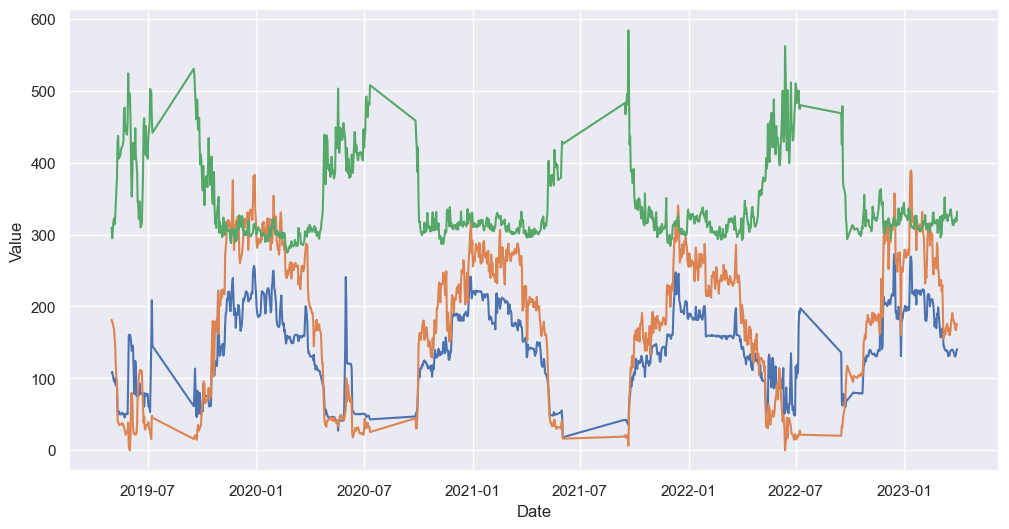

In [72]:
sns.set(rc={'figure.figsize': (12, 6)})

sns.lineplot(data=data, x='Дата', y='Выработка электроэнергии ТА гр.130')
sns.lineplot(data=data, x='Дата', y='Отпуск тепла из ТО ТА гр.130')
sns.lineplot(data=data, x='Дата', y='Удельный расход условного топлива на отпуск э/э гр.130').set(xlabel='Date', ylabel='Value')

### **Разделим на фичи**

In [73]:
date = np.array([[0, 0, 0]], dtype=int)
for i in data['Дата']:
    date = np.vstack([date, str(i.date()).split("-")])

In [74]:
date = date[1:]

In [75]:
data['year'] = date[:, 0]
data['year'] = data['year'].map(int)

data['month'] = date[:, 1]
data['month'] = data['month'].map(int)

data['day'] = date[:, 2]
data['day'] = data['day'].map(int)

In [76]:
data = data.drop(columns=['Дата'])

<Axes: >

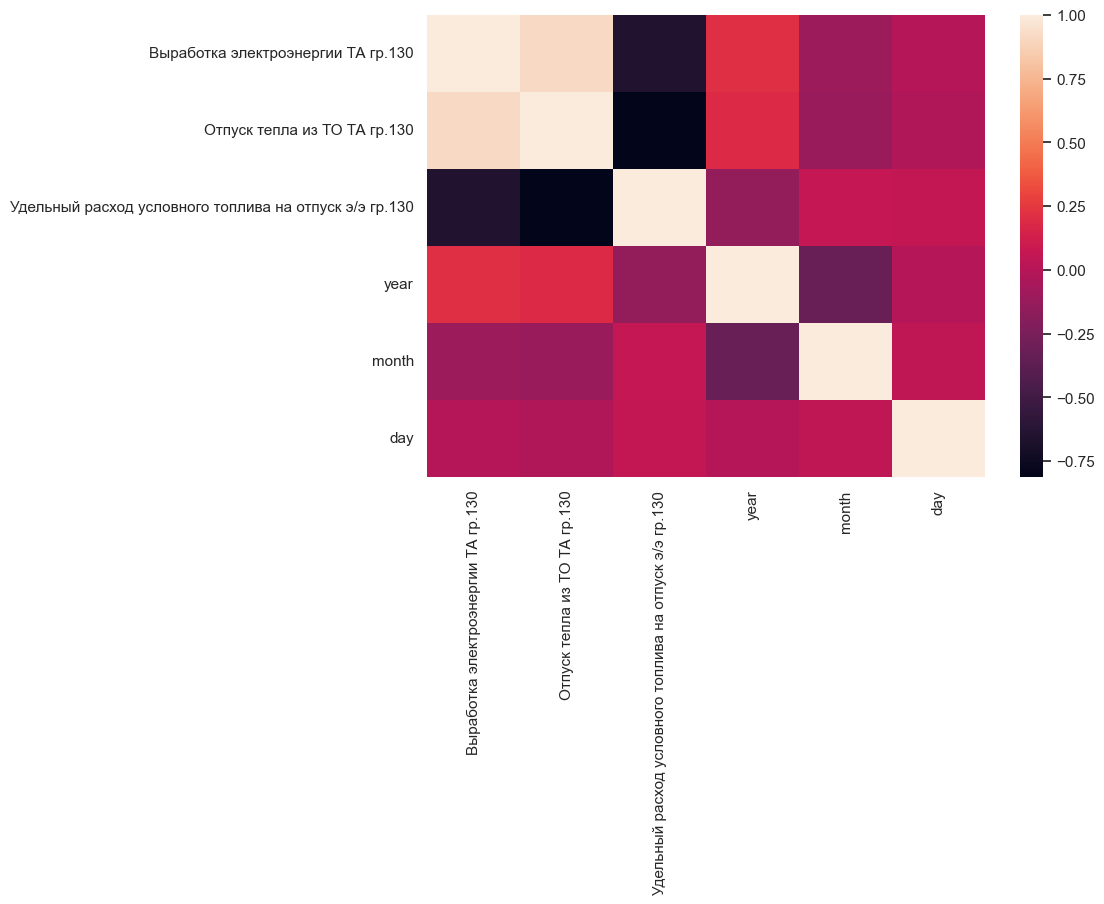

In [77]:
dataCorr = data.corr()

sns.set(rc={'figure.figsize': (9, 6)})

sns.heatmap(dataCorr)

### **Делим на тестовую и тренировочную**

In [78]:
X_WITH_FICH = data.drop(columns=['Удельный расход условного топлива на отпуск э/э гр.130'])
Y_WITH_FICH = data['Удельный расход условного топлива на отпуск э/э гр.130']

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(X_WITH_FICH, Y_WITH_FICH, test_size=0.15, random_state=42)

### **Протестируем модели**

In [51]:
cbr.fit(X_train, Y_train, verbose=500)

prediction_cbr = cbr.predict(X_test)

Learning rate set to 0.040449
0:	learn: 52.6619158	total: 1.98ms	remaining: 1.98s
500:	learn: 8.5814461	total: 841ms	remaining: 838ms
999:	learn: 5.8605906	total: 2s	remaining: 0us


In [53]:
cbr_litlleBit_params.fit(X_train, Y_train)

prediction_cbr_litlleBit_params = cbr_litlleBit_params.predict(X_test)

Learning rate set to 0.015297
0:	learn: 53.7896521	total: 11.7ms	remaining: 58.3s
1000:	learn: 4.2127034	total: 6.63s	remaining: 26.5s
2000:	learn: 1.5829102	total: 16.1s	remaining: 24.2s
3000:	learn: 0.7150988	total: 25.1s	remaining: 16.7s
4000:	learn: 0.3457043	total: 33.3s	remaining: 8.33s
5000:	learn: 0.1740896	total: 41.5s	remaining: 0us


In [55]:
search_CBR.fit(X_train, Y_train)

prediction_search_CBR = search_CBR.predict(X_test)

0:	learn: 54.1129753	total: 16ms	remaining: 1m 19s
1000:	learn: 9.2417255	total: 7.87s	remaining: 31.4s
2000:	learn: 6.0383015	total: 17.9s	remaining: 26.8s
3000:	learn: 4.5368860	total: 25.8s	remaining: 17.2s
4000:	learn: 3.2994760	total: 33.9s	remaining: 8.47s
5000:	learn: 2.4177300	total: 42.1s	remaining: 0us


In [57]:
rfr.fit(X_train, Y_train)

prediction_rfr = rfr.predict(X_test)

In [59]:
search_rfr.fit(X_train, Y_train)

prediction_search_rfr = search_rfr.predict(X_test)

In [62]:
comparison_table = pd.DataFrame(
    {'models': ['rfr', 'search_rfr', 'cbr', 'cbr_litlleBit_params', 'search_CBR'],
     
    'mean_squared_error': [math.sqrt(mean_squared_error(Y_test, prediction_rfr)),
                            math.sqrt(mean_squared_error(Y_test, prediction_search_rfr)),
                            math.sqrt(mean_squared_error(Y_test, prediction_cbr)),
                            math.sqrt(mean_squared_error(Y_test, prediction_cbr_litlleBit_params)),
                            math.sqrt(mean_squared_error(Y_test, prediction_search_CBR))],

    'mean_absolute_error':[mean_absolute_error(Y_test, prediction_rfr),
                           mean_absolute_error(Y_test, prediction_search_rfr),
                           mean_absolute_error(Y_test, prediction_cbr),
                           mean_absolute_error(Y_test, prediction_cbr_litlleBit_params),
                           mean_absolute_error(Y_test, prediction_search_CBR)],\

    'median_absolute_error': [median_absolute_error(Y_test, prediction_rfr),
                              median_absolute_error(Y_test, prediction_search_rfr),
                              median_absolute_error(Y_test, prediction_cbr),
                              median_absolute_error(Y_test, prediction_cbr_litlleBit_params),
                              median_absolute_error(Y_test, prediction_search_CBR)],
                              
    'r2_score': [r2_score(Y_test, prediction_rfr),
                r2_score(Y_test, prediction_search_rfr),
                r2_score(Y_test, prediction_cbr),
                r2_score(Y_test, prediction_cbr_litlleBit_params),
                r2_score(Y_test, prediction_search_CBR)]
    })
comparison_table

,models,mean_squared_error,mean_absolute_error,median_absolute_error,r2_score
0,rfr,11.321137,8.118734,6.101382,0.960470
1,search_rfr,12.010967,8.760165,6.927643,0.955506
2,cbr,11.500480,8.403751,6.286031,0.959208
3,cbr_litlleBit_params,11.854771,8.273562,5.769244,0.956656
4,search_CBR,12.150026,8.371352,5.663205,0.954470


# **Поданным результатам я бы выделил два победителя rfr и cbr_litlleBit_params так что сохраним два их вида предваритеьно обучив**

In [81]:
cbr_litlleBit_params.fit(X_WITH_FICH, Y_WITH_FICH)

prediction_cbr_litlleBit_params_Fich = cbr_litlleBit_params.predict(X_WITH_FICH)

joblib.dump(cbr_litlleBit_params, 'cbr_litlleBit_params_WITH_FICH.pkl')

Learning rate set to 0.015627
0:	learn: 54.1470157	total: 12ms	remaining: 1m
1000:	learn: 4.1324147	total: 7.84s	remaining: 31.4s
2000:	learn: 1.6649318	total: 17.2s	remaining: 25.8s
3000:	learn: 0.7944061	total: 27.3s	remaining: 18.2s
4000:	learn: 0.4017731	total: 37.4s	remaining: 9.34s
5000:	learn: 0.2106603	total: 47.2s	remaining: 0us


['cbr_litlleBit_params_WITH_FICH.pkl']

In [82]:
cbr_litlleBit_params.fit(X, Y)

prediction_cbr_litlleBit_params = cbr_litlleBit_params.predict(X)

joblib.dump(cbr_litlleBit_params, 'cbr_litlleBit_params_notWITH_FICH.pkl')

Learning rate set to 0.015627
0:	learn: 54.1521133	total: 14.4ms	remaining: 1m 12s
1000:	learn: 8.9197147	total: 8.2s	remaining: 32.8s
2000:	learn: 7.1169246	total: 17.7s	remaining: 26.5s
3000:	learn: 6.3843942	total: 26.6s	remaining: 17.8s
4000:	learn: 6.0349473	total: 35.6s	remaining: 8.9s
5000:	learn: 5.8436646	total: 46.8s	remaining: 0us


['cbr_litlleBit_params_notWITH_FICH.pkl']

In [84]:
rfr.fit(X_WITH_FICH, Y_WITH_FICH)

prediction_rfr_Fich = rfr.predict(X_WITH_FICH)

joblib.dump(rfr, 'rfr_WITH_FICH.pkl')

['rfr_WITH_FICH.pkl']

In [85]:
rfr.fit(X, Y)

prediction_rfr = rfr.predict(X)

joblib.dump(rfr, 'rfr_notWITH_FICH.pkl')

['rfr_notWITH_FICH.pkl']

In [87]:
comparison_table = pd.DataFrame(
    {'models': ['rfr', 'rfr_Fich', 'cbr_litlleBit_params', 'cbr_litlleBit_params_Fich'],
     
    'mean_squared_error': [math.sqrt(mean_squared_error(Y, prediction_rfr)),
                            math.sqrt(mean_squared_error(Y_WITH_FICH, prediction_cbr_litlleBit_params_Fich)),
                            math.sqrt(mean_squared_error(Y, prediction_cbr_litlleBit_params)),
                            math.sqrt(mean_squared_error(Y_WITH_FICH, prediction_cbr_litlleBit_params_Fich))],

    'mean_absolute_error':[mean_absolute_error(Y, prediction_rfr),
                           mean_absolute_error(Y_WITH_FICH, prediction_cbr_litlleBit_params_Fich),
                           mean_absolute_error(Y, prediction_cbr_litlleBit_params),
                           mean_absolute_error(Y_WITH_FICH, prediction_cbr_litlleBit_params_Fich)],\

    'median_absolute_error': [median_absolute_error(Y, prediction_rfr),
                              median_absolute_error(Y_WITH_FICH, prediction_cbr_litlleBit_params_Fich),
                              median_absolute_error(Y, prediction_cbr_litlleBit_params),
                              median_absolute_error(Y_WITH_FICH, prediction_cbr_litlleBit_params_Fich)],
                              
    'r2_score': [r2_score(Y, prediction_rfr),
                r2_score(Y_WITH_FICH, prediction_cbr_litlleBit_params_Fich),
                r2_score(Y, prediction_cbr_litlleBit_params),
                r2_score(Y_WITH_FICH, prediction_cbr_litlleBit_params_Fich)]
    })
comparison_table

,models,mean_squared_error,mean_absolute_error,median_absolute_error,r2_score
0,rfr,7.037606,4.628736,2.971568,0.983466
1,rfr_Fich,0.210653,0.162553,0.127812,0.999985
2,cbr_litlleBit_params,5.843667,3.011736,1.693668,0.988600
3,cbr_litlleBit_params_Fich,0.210653,0.162553,0.127812,0.999985
